In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime

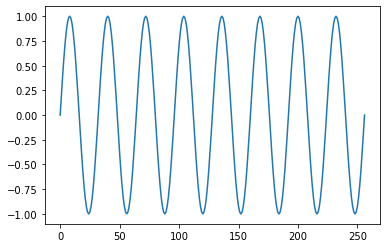

In [2]:
# create sine wave data

steps = 257

sine_data = []

for i in range(steps):
    time = np.sin(i * (1/16) * (np.pi))
    sine_data.append(time)

plt.plot(sine_data)

In [3]:
# Create data loader


from torch.utils.data import TensorDataset, DataLoader


def batch_data(log_returns, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param log_returns: asset's daily log returns
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    
    # total number of batches we can make
    n_batches = len(log_returns)//batch_size
    
    # Keep only enough values to make full batches
    log_returns = log_returns[:n_batches * batch_size]
    
    y_len = len(log_returns) - sequence_length
    
    x, y = [], []
    for idx in range(0, y_len):
        idx_end = sequence_length + idx
        x_batch = log_returns[idx:idx_end]
        x.append(x_batch)
        # only making predictions after the last word in the batch
        batch_y = log_returns[idx_end]    
        y.append(batch_y)    
    
    # create tensor datasets
    x_tensor = torch.from_numpy(np.asarray(x))
    y_tensor = torch.from_numpy(np.asarray(y))
    
    # make x_tensor 3-d instead of 2-d
    # comment the next line when using the sine data
    x_tensor = x_tensor.unsqueeze(-1)
    
    data = TensorDataset(x_tensor, y_tensor)
    
    data_loader = DataLoader(data, shuffle=False, batch_size=batch_size)
    
    # return a dataloader
    return data_loader

In [4]:
# test dataloader on subset of actual data

test_text = sine_data # real data
t_loader = batch_data(test_text, sequence_length=16, batch_size=4)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(data_iter.next()[0].size()[0])
print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

4
torch.Size([4, 16, 1])
tensor([[[ 0.0000e+00],
         [ 1.9509e-01],
         [ 3.8268e-01],
         [ 5.5557e-01],
         [ 7.0711e-01],
         [ 8.3147e-01],
         [ 9.2388e-01],
         [ 9.8079e-01],
         [ 1.0000e+00],
         [ 9.8079e-01],
         [ 9.2388e-01],
         [ 8.3147e-01],
         [ 7.0711e-01],
         [ 5.5557e-01],
         [ 3.8268e-01],
         [ 1.9509e-01]],

        [[ 1.9509e-01],
         [ 3.8268e-01],
         [ 5.5557e-01],
         [ 7.0711e-01],
         [ 8.3147e-01],
         [ 9.2388e-01],
         [ 9.8079e-01],
         [ 1.0000e+00],
         [ 9.8079e-01],
         [ 9.2388e-01],
         [ 8.3147e-01],
         [ 7.0711e-01],
         [ 5.5557e-01],
         [ 3.8268e-01],
         [ 1.9509e-01],
         [ 1.2246e-16]],

        [[ 3.8268e-01],
         [ 5.5557e-01],
         [ 7.0711e-01],
         [ 8.3147e-01],
         [ 9.2388e-01],
         [ 9.8079e-01],
         [ 1.0000e+00],
         [ 9.8079e-01],
         [ 

In [5]:
class AssetRNN(nn.Module):
    
    def __init__(self, input_dim, output_dim, n_hidden, n_layers, dropout=0.25, lr=0.001):
        super().__init__()
        
        # set class variables
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        # define model layers
        
        # define rnn layer
        self.rnn = nn.RNN(input_dim, n_hidden, n_layers, batch_first=True, dropout=dropout)
        
        # define a dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, output_dim)   
    
    
    def forward(self, nn_input, hidden):
        
        # batch_size equals the input's first dimension
        batch_size = nn_input.size(0)
        
        # Get the outputs and the new hidden state from the rnn
        r_output, hidden = self.rnn(nn_input, hidden)
        
        # pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up RNN outputs using view
        # contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        # put nn_input through the fully-connected layer
        out = self.fc(out)

        # reshape into (batch_size, seq_length, output_size)
        out = out.view(batch_size, -1, self.output_dim)
        
        # get last batch
        out = out[:, -1]
        
        # return the final output and the hidden state
        return out, hidden
    
"""    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return torch.stack(hidden)
"""

"    \n    def init_hidden(self, batch_size):\n        ''' Initializes hidden state '''\n        # Create two new tensors with sizes n_layers x batch_size x n_hidden,\n        # initialized to zero, for hidden state and cell state of LSTM\n        weight = next(self.parameters()).data\n        \n        if (train_on_gpu):\n            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),\n                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())\n        else:\n            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),\n                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())\n        \n        return torch.stack(hidden)\n"

In [6]:
# define and print a model to make sure above code works
input_dim = 1
output_dim = 1
n_hidden = 32
n_layers = 2
drop_prob = 0.25
lr = 0.001

net = AssetRNN(input_dim, output_dim, n_hidden, n_layers, drop_prob, lr)
print(net)

AssetRNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [8]:
# accumulate inputs, targets, and predictions for later analysis
x_actuals_train = []
y_actuals_train = []
y_hats_train = []

def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param decoder: The PyTorch Module that holds the neural network
    :param decoder_optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    
    # move data to GPU, if available
    if(train_on_gpu):
        inp, target = inp.cuda(), target.cuda()
    
    if(train_on_gpu):
        rnn.cuda()

    if hidden is not None:
        hidden = hidden.detach()
    
    # zero accumulated gradients
    rnn.zero_grad()
    
    # get the output and new hidden state from the model
    output, hidden = rnn(inp, hidden)
    
    # perform backpropagation and optimization
    loss = criterion(output, target)
    loss.backward() # calculates the gradients
    
    # clip gradient to prevent exploding gradient
    nn.utils.clip_grad_norm_(rnn.parameters(), 5)

    optimizer.step() # updates the weights of the network by subtracting lr*gradient
    
    # accumulate inputs, targets, and predictions for later analysis
    x_actuals_train.append(inp)
    y_actuals_train.append(target)
    y_hats_train.append(output)

    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), hidden

In [9]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches):
    batch_losses = []
    batch_losses_agg = []
    
    rnn.train()
    
    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        # by setting to None, will default to the code provided below:
        # https://github.com/pytorch/pytorch/blob/e44b2b72bd4ccecf9c2f6c18d09c11eff446b5a3/torch/nn/modules/rnn.py#L251
        hidden = None
        #hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop        
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs.float(), labels.float(), hidden) 
            # record loss
            batch_losses.append(loss)

            # print loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses_agg.append(np.average(batch_losses))
                batch_losses = []
 
    # plot the training loss across epochs
    batch_losses_agg = np.array(batch_losses_agg)
    plt.plot(batch_losses_agg)
    plt.title("Training Losses")
    
    # returns a trained rnn
    return rnn

In [29]:
# Data params

# Sequence Length ... number of items in a sequence
sequence_length = 20

# Batch Size
batch_size = 8

# input data to use for training
nn_input = sine_data

# data loader
train_loader = batch_data(nn_input, sequence_length, batch_size)

In [30]:
# Training parameters

# Number of Epochs
num_epochs = 50

# Learning Rate
learning_rate = 0.002


# Model parameters

# input size
input_size = 1

# output size
output_size = 1

# Hidden Dimension
hidden_dim = 32

# Number of RNN Layers
n_layers = 2

# dropout probability
drop_pr = 0.25

# Show stats for every n number of batches
show_every_n_batches = 5

Training for 50 epoch(s)...
Epoch:    1/50    Loss: 0.5090931355953217

Epoch:    1/50    Loss: 0.3978627175092697

Epoch:    1/50    Loss: 0.3693947851657867



C:\Users\Matt\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:    1/50    Loss: 0.2819743663072586

Epoch:    1/50    Loss: 0.26502086520195006

Epoch:    2/50    Loss: 0.1986073288652632

Epoch:    2/50    Loss: 0.24575680047273635

Epoch:    2/50    Loss: 0.21438953876495362

Epoch:    2/50    Loss: 0.23325231075286865

Epoch:    2/50    Loss: 0.20472846329212188

Epoch:    3/50    Loss: 0.18472620182567173

Epoch:    3/50    Loss: 0.2543739855289459

Epoch:    3/50    Loss: 0.16831329166889192

Epoch:    3/50    Loss: 0.2196172669529915

Epoch:    3/50    Loss: 0.20022554844617843

Epoch:    4/50    Loss: 0.19728571962979105

Epoch:    4/50    Loss: 0.21409950256347657

Epoch:    4/50    Loss: 0.17730342075228692

Epoch:    4/50    Loss: 0.2284178040921688

Epoch:    4/50    Loss: 0.1896646164357662

Epoch:    5/50    Loss: 0.17798065435555246

Epoch:    5/50    Loss: 0.24003410190343857

Epoch:    5/50    Loss: 0.1636281728744507

Epoch:    5/50    Loss: 0.21985013484954835

Epoch:    5/50    Loss: 0.16364689096808432

Epoch:    6/50   

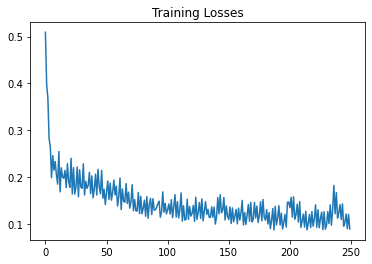

In [31]:
### TRAIN THE MODEL ###

# create model and move to gpu if available
rnn = AssetRNN(input_size, output_size, hidden_dim, n_layers, dropout=0.25)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# train the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# save the trained model
torch.save(rnn.state_dict(), 'trained_rnn')
print('Model Trained and Saved')

# save trained model's parameters to be used later without having to re-train
checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_dim': hidden_dim,
              'n_layers': n_layers,
              'state_dict': rnn.state_dict()}

torch.save(checkpoint, 'checkpoint_rnn.pth')
print('Model Checkpointed')

<class 'list'>
[[-0.09327856451272964], [0.3585641384124756], [0.39862120151519775], [0.5558801293373108], [0.6915524005889893], [0.7989009022712708], [0.616461455821991], [0.8491514921188354]]


Text(0.5, 1.0, 'y_actuals and y_hats')

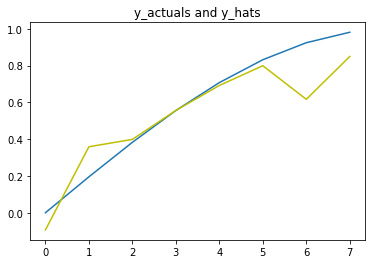

In [28]:
"""
### TRAINING DATA VISUALIZATION###


# get the 1st batch of y_actuals
i = 100
#i_y_actuals_train = y_actuals_train[i]
i_y_actuals_train = y_actuals_train[i]

# convert the 1st batch of y_actuals to a list
to_list_y_actuals_train = i_y_actuals_train.tolist()


# get the 1st batch of y_hats
i_y_hats_train = y_hats_train[i]

# convert the 1st batch of y_actuals to a list
to_list_y_hats_train = i_y_hats_train.tolist()


print(type(to_list_y_hats_train))
print(to_list_y_hats_train)


# plot the y_actuals
# batch_losses_agg = np.array(batch_losses_agg)
plt.plot(to_list_y_actuals_train)
plt.plot(to_list_y_hats_train, 'y')
plt.title("y_actuals and y_hats")
"""